## **Object Detection - Face Mask Detection :** 

**Dataset link :** https://www.kaggle.com/wobotintelligence/face-mask-detection-dataset

### Download Dataset using kaggle api:

In [5]:
# Uploading dataset from kaggle
from google.colab import files
files.upload()

# downloading google api client
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# download api link
!kaggle datasets download -d wobotintelligence/face-mask-detection-dataset


Saving kaggle.json to kaggle.json
100% 2.49G/2.50G [00:32<00:00, 48.1MB/s]
100% 2.50G/2.50G [00:32<00:00, 82.1MB/s]


In [6]:
# unzipping the files
import zipfile
from google.colab import drive

zip_ref = zipfile.ZipFile("/content/face-mask-detection-dataset.zip", 'r')
zip_ref.extractall("/content/Dataset")
zip_ref.close()

### Importing Library:

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import *
from PIL import Image, ImageDraw, ImageFont
from torchvision import transforms

### Preparing the dataset:

In [8]:
# creating a new folder and subfolders containing dataset and annotations
os.mkdir("/content/FaceMask_Dataset")
root_dir= "/content/FaceMask_Dataset"

folders= ["train_images","test_images", "annotations"]

for f in folders:
  os.mkdir(os.path.join(root_dir, f))

In [9]:
print("Images Length: ",len(os.listdir("/content/Dataset/Medical mask/Medical mask/Medical Mask/images")))
print("Annotations length: ",len(os.listdir("/content/Dataset/Medical mask/Medical mask/Medical Mask/annotations")))

Images Length:  6024
Annotations length:  4326


Here, We could see that lengths are different which means there are no annotations for some images. So,lets take only 4326 images which contains same name.

In [10]:
train_data= pd.read_csv("/content/Dataset/train.csv")
train_data.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [11]:
# counts of each object present in the images
class_len= train_data["classname"].value_counts().sum()
print("Total classes present in the images: ",class_len)

train_data["classname"].value_counts()

Total classes present in the images:  15412


face_with_mask              4180
mask_surgical               2430
mask_colorful               1876
face_no_mask                1569
face_other_covering         1372
eyeglasses                   914
hat                          823
sunglasses                   358
hair_net                     287
scarf_bandana                260
goggles                      192
helmet                       187
hijab_niqab                  173
face_shield                  160
hood                         159
face_with_mask_incorrect     150
balaclava_ski_mask           134
turban                        94
gas_mask                      55
other                         39
Name: classname, dtype: int64

In [12]:
# moving all files into respective subfolders
def move_files(data, source_dir, dest_dir):

  files= data["name"].unique()
  
  annotation_path= os.path.join(source_dir, "annotations")
  images_path= os.path.join(source_dir, "images")

  for fname in files:
    # moving the images
    shutil.move(src= os.path.join(images_path, fname), dst= os.path.join(dest_dir,"train_images",fname.split(".")[0]+".png"))
    shutil.move(src= os.path.join(annotation_path, fname+".json"), dst= os.path.join(dest_dir,"annotations",fname.split('.')[0]+".json")) 
  
  # remaining images to test folder
  rem_images= os.listdir(os.path.join(source_dir, "images"))

  for f in rem_images:
    shutil.move(src= os.path.join(images_path,f), dst= os.path.join(dest_dir,"test_images",f.split(".")[0]+".png")) 
  print("Annotations and dataset are moved to the FaceMask_Dataset folder")

In [13]:
# move files to the subfolders
move_files(data= train_data, source_dir= "/content/Dataset/Medical mask/Medical mask/Medical Mask", dest_dir= "/content/FaceMask_Dataset")

Annotations and dataset are moved to the FaceMask_Dataset folder


In [14]:
# removing the old Folder
shutil.rmtree("/content/Dataset")

### Creating a data list:

In [15]:
# from utils.py to create images ,boxes and labels in a json file and store it in a folder
create_data_lists(root_dir= "/content/FaceMask_Dataset", output_dir= "/content")


There are 4319 training images containing a total of 8638 objects. Files have been saved to /content.

There are 1698 test images. Files have been saved to /content.


### Detection:

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model checkpoint
checkpoint = '/content/drive/MyDrive/practice deep learning/Object Detection/checkpoint_ssd300.pth.tar'
checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = checkpoint['model']
model = model.to(device)




Loaded checkpoint from epoch 29.



In [3]:
file= open("/content/label_map.json",'r')
label_map= json.load(file)

rev_label_map = {v: k for k, v in label_map.items()}  # Inverse mapping

In [4]:
model.eval()

SSD300(
  (base): VGGBase(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), 

In [5]:
# Transforms
resize_img = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [17]:
def detect(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.
    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """
    result_image= resize_img(original_image)
    # Transform
    image = normalize(to_tensor(resize_img(original_image)))
    
    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))
    
    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)
    
    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [result_image.width, result_image.height, result_image.width, result_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]
    
    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = result_image
    draw = ImageDraw.Draw(annotated_image)
    #print(det_boxes, det_labels, det_scores)
    font = ImageFont.truetype("arial.ttf", 15)
    
    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])  # a second rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 2. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a third rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 3. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a fourth rectangle at an offset of 1 pixel to increase line thickness

        # Text
        text_size = font.getsize(det_labels[i].upper())
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',
                  font=font)
    del draw

    return annotated_image


In [28]:
# random 3 images from the splitted test folder
test_path= '/content/FaceMask_Dataset/test_images'
test_image_paths = os.listdir(test_path)

test_images= np.random.choice(test_image_paths, size= 3, replace= False)

/content/model.py:492: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/content/model.py:494: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  image_scores.append(class_scores[1 - suppress])


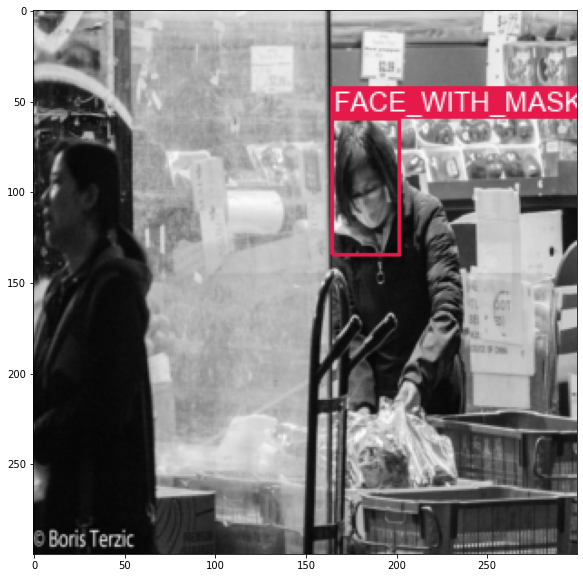

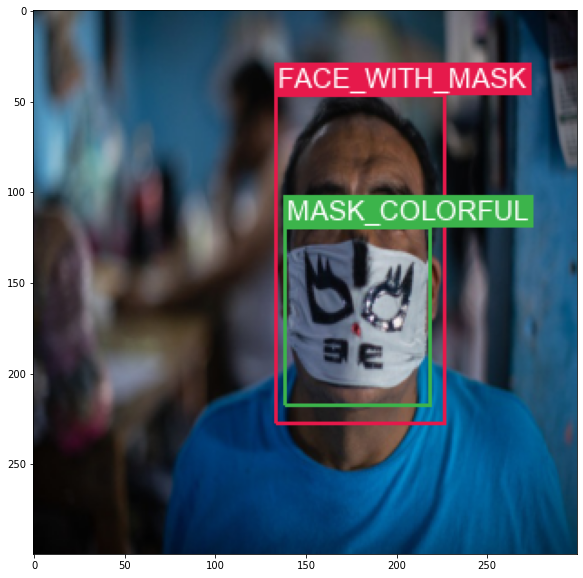

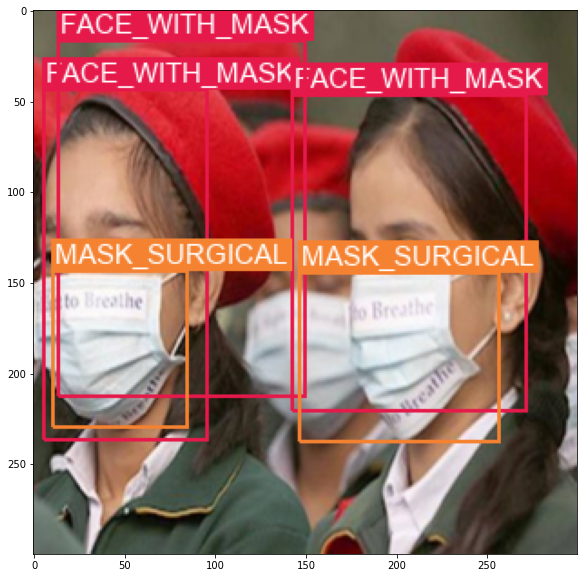

In [30]:
# Image detection
for fname in test_images:
  plt.figure(figsize = (10,10))
  img_path= os.path.join(test_path, fname)
  original_image = Image.open(img_path, mode='r')
  original_image = original_image.convert('RGB')
  
  im= detect(original_image, min_score=0.6, max_overlap=0.5, top_k=200)
  im2array= np.array(im)
  plt.imshow(im2array)
  plt.show()